In [145]:
import torch

import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from torch.nn import *

In [2]:
n_batches = 64

# Скачиваем размеченный датасет
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))
])

dataset = CIFAR10('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=n_batches, shuffle=True)

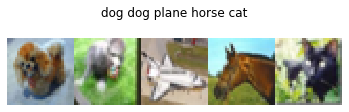

In [204]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(dataloader)
images, targets = dataiter.next()

imshow(torchvision.utils.make_grid(images[:5], padding=0))
plt.title(' '.join([classes[targets[i]] for i in range(5)]) + "\n")
plt.show()

In [222]:
images.size()

torch.Size([64, 3, 32, 32])

# Util function

def plot_image(image, shape=[32, 32, 3]):
#     npimg = image.numpy()
    plt.imshow( ((image.reshape(shape))*255).astype(np.uint8), interpolation="nearest" )
    plt.axis('off')

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow( ( (np.transpose(npimg, (1, 2, 0)))*255).astype(np.uint8) , interpolation='nearest' )
    plt.axis('off')


In [96]:
# DEFINE A MODEL

class VarAE(nn.Module):
    
    def __init__(self, in_size, hid1_size, hid2_size):
        super(VarAE, self).__init__()
        
        self.fc1 = nn.Linear(3072, 500)
        
        self.fc21 = nn.Linear(500, 20)
        self.fc22 = nn.Linear(500, 20)
        
        self.fc3 = nn.Linear(20, 500)
        self.fc4 = nn.Linear(500, 3072)
        
    def encode(self, x): # activation 
#         print("size of x ", x.size())
        h1 = F.relu( torch.FloatTensor(self.fc1(x)  ) )
        return self.fc21(h1), self.fc22(h1)
    
    def reparam(self, mu, gamma):
        std = torch.exp(gamma/2)
        noise = torch.FloatTensor(std.size()).normal_()
        noise = torch.autograd.Variable(noise)
        return  (noise * std + mu)
    
    def decode(self, z):
        h3 = F.elu( self.fc3(z) ) # TypeError: elu(): argument 'input' (position 1) must be Tensor, not Linear
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, gamma = self.encode(x)
        z = self.reparam(mu, gamma)

        return self.decode(z), mu, gamma

In [154]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()
        
        self.fc1 = Linear(3072, 1536)
        self.fc2 = Linear(1536, 768)
        
        self.fc31 = Linear(768, 30) 
        self.fc32 = Linear(768, 30)
        
        self.fc4 = Linear(30, 768)
        self.fc5 = Linear(768, 1536)
        self.fc6 = Linear(1536, 3072)
        
    def encode(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        return self.fc31(x), self.fc32(x)
    
    def reparametrize(self, mu, gamma):
        std = torch.exp(gamma/2)
        normal_noise = torch.FloatTensor(std.size()).normal_()
        normal_noise = torch.autograd.Variable(normal_noise)
        return normal_noise * std + mu

    def decode(self, x):
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x
    
    def forward(self, x):
        mu, gamma = self.encode(x)
        z = self.reparametrize(mu, gamma)
        
        return self.decode(z), mu, gamma
        

In [155]:
model = vae()  # вторая модель, где больше слове -- быстрее будет обучаться?

In [156]:

reconstruction_loss = nn.MSELoss(reduction='sum')

def loss_fn(gen, orig, mu, gamma):
    rec_loss = reconstruction_loss(gen, orig)
    
    KL_loss = 0.5 * torch.sum(torch.exp(gamma) + torch.pow(mu, 2) - 1 - gamma)
    
    return KL_loss + rec_loss

opt = optim.Adam(model.parameters(), lr=1e-3)



In [157]:
n_epoches = 10

losses = []

for ep in range(n_epoches):
    model.train()  # turn on 'train mode'
    overall_loss = 0
    
    for batch_idx, data in enumerate(dataloader):
        
        img, _ = data
        
        img = img.view(img.size(0), -1)
#         print("size into train ", img.size())
        img = torch.autograd.Variable(img)
        
        opt.zero_grad()
        reconstruction, mu, gamma = model.forward(img)
        
        loss = loss_fn(reconstruction, img, mu, gamma)
        
        loss.backward()
        
        overall_loss += loss.item()
        opt.step()
        
        losses.append(loss.item())
        
    if ep % 2 == 0 :
        print("ep #{}, overall loss={}, current batch loss={}".format(ep, 
                                                                      overall_loss/len(dataloader.dataset), 
                                                                      loss.item()/len(img)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ep #0, overall loss=612.710572734375, current batch loss=477.367919921875


KeyboardInterrupt: 

In [128]:
# Let's generate new images

coding = torch.normal(mean=1, std=1, size=(10, 20))

outvals = model.decode(coding)

ax = []
fig = plt.figure(figsize=(15, 6))

for i in range(10)
    ax.append(fig.add_subplot(2, 5, i+1))
    plot_image(outvals[i].detach().numpy())

In [129]:
outvals.shape

torch.Size([10, 3072])

In [249]:
outvals_np = outvals[2].detach().numpy()


In [250]:
def reshape(image):
    return np.reshape(image, (3, 32, 32))

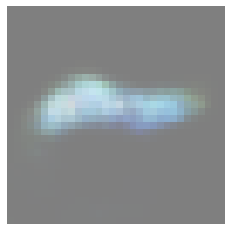

In [251]:
imshow( torch.tensor( reshape(outvals_np)) )